In [1]:
# Load basic libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

In [2]:
df = pd.read_csv("ratings_Beauty.csv")
print(df.columns)
print(df.shape)

Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')
(2023070, 4)


## Univariate Variable Analysis



In [3]:
df = df.rename(columns={'UserId': 'UserID', 'ProductId': 'ProductID'})

In [4]:
df.describe(include=['object'])

,UserID,ProductID
count,2023070,2023070
unique,1210271,249274
top,A3KEZLJ59C1JVH,B001MA0QY2
freq,389,7533


In [142]:
df.head(3)

,UserID,ProductID,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200


## Basic Data Analysis



<h4>Check for Duplicate Values</h4>

In [143]:
columns_to_check_duplicates = df.columns
duplicated = df.duplicated(subset=columns_to_check_duplicates, keep=False)
duplicate_rows = df[duplicated]

if not duplicate_rows.empty:
    print("Duplicate records found:")
    print(duplicated.sum())
else:
    print("No duplicate records found.")

No duplicate records found.


<h4>Handle Null Values</h4>

In [144]:
null_counts = df.isnull().sum()
null_table = pd.DataFrame(null_counts, columns=["Null Count"])
null_table

,Null Count
UserID,0
ProductID,0
Rating,0
Timestamp,0



## Feature Engineering



<h4>Genrate new features</h4>

In [145]:
df['Datetime'] = df['Timestamp'].apply(lambda x: datetime.utcfromtimestamp(x))
df['Month'] = df['Datetime'].apply(lambda x: x.strftime('%m'))
df['Year'] = df['Datetime'].apply(lambda x: x.strftime('%Y'))

df.head(3)

,UserID,ProductID,Rating,Timestamp,Datetime,Month,Year
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200,2013-05-28,05,2013
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200,2012-12-14,12,2012
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200,2014-07-07,07,2014


<h2>Visualization</h2>

In [146]:
df['UserID'].value_counts().head(10)

UserID
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
ALQGOMOY1F5X9     275
AKMEY1BSHSDG7     269
A3R9H6OKZHHRJD    259
A1M04H40ZVGWVG    249
A1RRMZKOMZ2M7J    225
Name: count, dtype: int64

<AxesSubplot: ylabel='Frequency'>

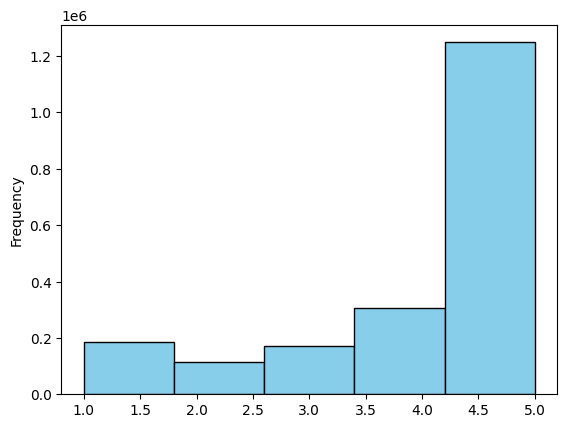

In [147]:
df['Rating'].plot(kind='hist', bins=5, color='skyblue', edgecolor='black')

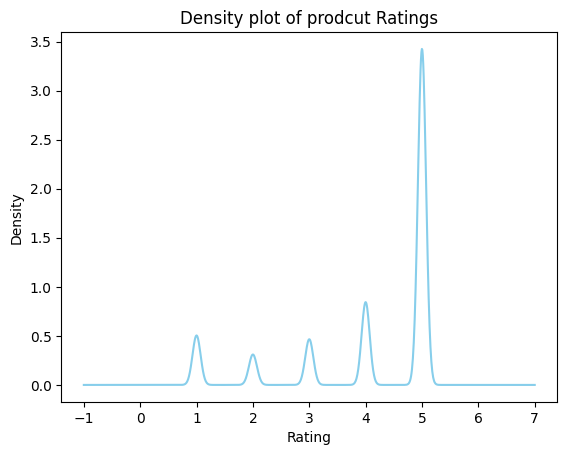

In [148]:
df['Rating'].plot(kind='density', color='skyblue')

plt.title('Density plot of prodcut Ratings')
plt.ylabel('Density')
plt.xlabel('Rating')
plt.show()

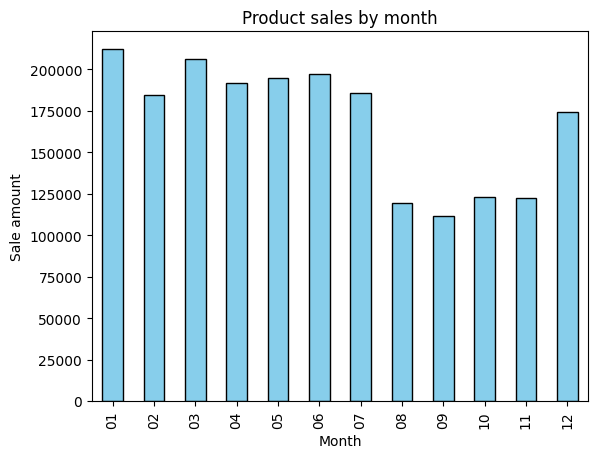

In [149]:
df['Month'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Product sales by month')
plt.ylabel('Sale amount')
plt.xlabel('Month')
plt.show()

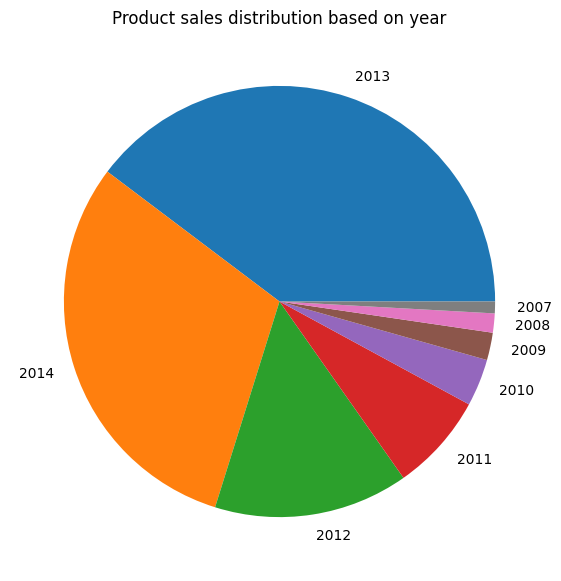

In [150]:
plt.figure(figsize=(7,7))

df['Year'].value_counts().head(8).plot(kind='pie')
plt.title('Product sales distribution based on year')
plt.ylabel('')
plt.show()

<h2>Matrix Factorizaton

In [151]:
# df = df.sample(frac=1).reset_index(drop=True)
factoriztion_df = df[['UserID', 'ProductID', 'Rating']].copy().head(100000)
user_item_matrix = factoriztion_df.pivot(index='UserID', columns='ProductID', values='Rating').fillna(0)

In [152]:
SVD = TruncatedSVD(n_components=20)
users_matrix = SVD.fit_transform(user_item_matrix)  # U⋅Σ
items_matrix = SVD.components_ # V-transposed

print(users_matrix.shape)
print(items_matrix.shape)

(91656, 20)
(20, 6384)


In [153]:
# Choose a user as an example
row_array = users_matrix[2, :]

In [154]:
recom = row_array.reshape(1, -1).dot(items_matrix)
recom.shape

(1, 6384)

In [155]:
recom.sort()
recom

array([[-0.11145368, -0.06691366, -0.04830443, ...,  0.09984467,
         0.14778911,  0.16830915]])

In [156]:
users_matrix

array([[-1.37792656e-09,  3.99477034e-07,  2.25804590e-06, ...,
         1.58825986e-04,  1.39909764e-04,  1.43294862e-04],
       [ 2.49078970e-06,  1.51579726e-05,  5.14617256e-05, ...,
        -9.98850120e-05, -4.09096501e-04, -9.24266989e-04],
       [ 3.20193224e-03,  4.62038617e-03,  6.90977318e-03, ...,
         2.37081745e-01,  2.01733857e-02,  1.28943508e-01],
       ...,
       [-3.32200130e-08,  3.93261012e-06, -4.95101618e-06, ...,
        -9.02508146e-05, -8.47235674e-05, -6.14367971e-04],
       [-2.79703814e-17,  8.54278859e-17, -5.02794168e-15, ...,
        -8.19653240e-13,  6.20033210e-13, -6.89255579e-13],
       [ 7.26938465e-06,  3.49892603e-05,  1.88318368e-04, ...,
        -2.27135630e-02,  1.84851635e-01, -6.52870862e-02]])

<h2> Clustering

Clustering Method: DBSCAN

In [5]:
cluster_df = df[['UserID', 'ProductID', 'Rating']].copy().head(50000)

label_encoder_user = LabelEncoder()
label_encoder_product = LabelEncoder()

cluster_df['UserID'] = label_encoder_user.fit_transform(cluster_df['UserID'])
cluster_df['ProductID'] = label_encoder_product.fit_transform(cluster_df['ProductID'])

user_item_matrix = cluster_df.pivot(index='UserID', columns='ProductID', values='Rating').fillna(0)

In [6]:
print(user_item_matrix.shape)
user_item_matrix.head()

(47017, 2581)


ProductID,0,1,2,3,4,5,6,7,8,9,...,2571,2572,2573,2574,2575,2576,2577,2578,2579,2580
UserID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
pca = PCA(n_components=20)
encoded_matrix = pca.fit_transform(user_item_matrix)
encoded_matrix.shape

(47017, 20)

In [8]:
encoded_df = pd.DataFrame(encoded_matrix)
encoded_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.185830,-0.044484,-0.012220,0.001948,0.037998,-0.073204,-0.049395,-0.016271,-0.001717,-0.023642,-0.031154,-0.046869,-0.020004,-0.027312,-0.040485,-0.032470,-0.001878,0.021055,0.023045,0.024688
1,-0.184940,-0.043945,-0.012129,0.001802,0.037459,-0.072175,-0.048685,-0.017398,-0.004352,-0.019587,-0.029873,-0.045209,-0.019442,-0.026835,-0.040004,-0.033310,-0.007173,0.015802,0.021345,0.023317
2,-0.190458,-0.049016,-0.013869,0.001743,0.043463,-0.081361,-0.056691,-0.018415,-0.002642,-0.029531,-0.037977,-0.058456,-0.026318,-0.042790,-0.043291,-0.053418,-0.003053,0.046806,0.025219,0.016421
3,-0.194565,-0.057243,-0.019040,0.003052,0.061376,-0.126649,-0.111065,0.929997,-0.071354,0.195030,0.052563,0.094206,0.018915,0.019562,0.022061,0.010648,-0.000279,-0.005292,-0.007861,-0.004245
4,-0.184070,-0.043581,-0.011961,0.001903,0.037200,-0.071750,-0.045497,-0.015658,-0.001650,-0.022768,-0.029986,-0.045021,-0.019114,-0.026110,-0.038833,-0.031177,-0.001951,0.020129,0.022050,0.023464


In [9]:
scaler = MinMaxScaler()
encoded_df = pd.DataFrame(scaler.fit_transform(encoded_df))

In [10]:
encoded_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.037114,0.086983,0.266927,0.482779,0.505200,0.195444,0.128358,0.256033,0.456415,0.440427,0.323212,0.220465,0.322445,0.317104,0.238425,0.235527,0.482434,0.465212,0.482536,0.399667
1,0.037286,0.087079,0.266942,0.482759,0.505112,0.195625,0.128482,0.255860,0.456069,0.441007,0.323372,0.220777,0.322527,0.317169,0.238497,0.235392,0.481706,0.464390,0.482302,0.399458
2,0.036222,0.086177,0.266668,0.482751,0.506098,0.194004,0.127093,0.255704,0.456293,0.439585,0.322363,0.218287,0.321517,0.314974,0.238003,0.232178,0.482273,0.469245,0.482835,0.398405
3,0.035430,0.084714,0.265855,0.482929,0.509039,0.186013,0.117664,0.401154,0.447283,0.471693,0.333628,0.246983,0.328164,0.323553,0.247831,0.242419,0.482654,0.461086,0.478281,0.395249
4,0.037454,0.087143,0.266968,0.482773,0.505069,0.195700,0.129034,0.256127,0.456423,0.440552,0.323357,0.220812,0.322576,0.317269,0.238673,0.235733,0.482424,0.465067,0.482399,0.399480


In [11]:
epsilon = 0.01
min_samples = 100

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
user_clusters = dbscan.fit_predict(encoded_df)

In [16]:
# Add the cluster labels to the DataFrame
user_df = pd.DataFrame()
user_df['Cluster'] = user_clusters

# Analyze the clusters
cluster_counts = user_df['Cluster'].value_counts()
print(cluster_counts.nunique())
print(cluster_counts)

47
Cluster
 0     31095
-1      4491
 3      1580
 10      438
 9       433
 19      415
 37      359
 7       330
 8       317
 25      287
 4       281
 46      280
 1       277
 39      266
 30      261
 28      244
 31      240
 43      236
 34      235
 35      229
 12      222
 18      215
 14      214
 2       214
 6       213
 36      201
 32      197
 24      189
 16      187
 13      184
 29      181
 17      180
 20      179
 38      173
 21      170
 22      164
 40      162
 15      158
 23      154
 45      152
 5       145
 26      143
 42      140
 41      130
 27      127
 33      115
 44      110
 11      104
Name: count, dtype: int64


In [14]:
user_df.head(30)

,Cluster
0,0
1,0
2,0
3,-1
4,0
5,0
6,0
7,0
8,1
9,0
